In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile, assemble
from qiskit_aer import Aer, AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import UnitaryGate

In [2]:
class classical_to_quantum:
    # def __init__(self, maze):
    def __init__(self):
        # self.maze = maze
        # self.n_pos_x_qubits = int(np.ceil(np.log2(self.maze.height)))
        # self.n_pos_y_qubits = int(np.ceil(np.log2(self.maze.width)))
        self.n_pos_x_qubits = 5
        self.n_pos_y_qubits = 5
        # if(self.n_pos_x_qubits > 5 or self.n_pos_y_qubits > 5):
            # print("Warning: the maze dimensions "+maze.height+" x "+maze.width+" are too large. This is going to run forever.")
        self.dim = 2**(self.n_pos_x_qubits+self.n_pos_y_qubits+2)
        self.unitary = np.zeros((self.dim, self.dim))

        # print(self.unitary)

    def edge(self, a, b, c, d):
        return 1

    def can_go_right(self, j, k):
        if(j == 2**self.n_pos_x_qubits-1):
            return 0
        if(not(self.edge(j, k, j+1, k))):
            return 0
        return 1
    
    def can_go_left(self, j, k):
        if(j == 0):
            return 0
        if(not(self.edge(j, k, j-1, k))):
            return 0
        return 1
    
    def can_go_up(self, j, k):
        if(k == 0):
            return 0
        if(not(self.edge(j, k, j, k-1))):
            return 0
        return 1
    
    def can_go_down(self, j, k):
        if(k == 2**self.n_pos_y_qubits-1):
            return 0
        if(not(self.edge(j, k, j, k+1))):
            return 0
        return 1
    
    def go_right(self, a, b, j, k): # move one step right & turn
        # print("\tright\t", a, b, j, k, self.get_line_index(a, b, j, k), " ", self.get_line_index((a+1)%2, (b+1)%2, j+1, k))
        # self.unitary[self.get_line_index(a, b, j, k), self.get_line_index((a+1)%2, (b+1)%2, j+1, k)] = 1
        self.unitary[self.get_line_index(a, b, j, k), self.get_line_index(a, b, j+1, k)] = 1
    
    def go_left(self, a, b, j, k): # move one step left & turn
        # print("\tleft\t", a, b, j, k, self.get_line_index(a, b, j, k), " ", self.get_line_index((a+1)%2, (b+1)%2, j-1, k))
        # self.unitary[self.get_line_index(a, b, j, k), self.get_line_index((a+1)%2, (b+1)%2, j-1, k)] = 1
        self.unitary[self.get_line_index(a, b, j, k), self.get_line_index(a, b, j-1, k)] = 1
    
    def go_up(self, a, b, j, k): # move one step up & turn 
        # print("\tup\t", a, b, j, k, self.get_line_index(a, b, j, k), " ", self.get_line_index((a+1)%2, (b+1)%2, j, k-1))
        # self.unitary[self.get_line_index(a, b, j, k), self.get_line_index((a+1)%2, (b+1)%2, j, k-1)] = 1
        self.unitary[self.get_line_index(a, b, j, k), self.get_line_index(a, b, j, k-1)] = 1
    
    def go_down(self, a, b, j, k): # move one step down & turn
        # print("\tdown\t", a, b, j, k, self.get_line_index(a, b, j, k), " ", self.get_line_index((a+1)%2, (b+1)%2, j, k+1))
        # self.unitary[self.get_line_index(a, b, j, k), self.get_line_index((a+1)%2, (b+1)%2, j, k+1)] = 1
        self.unitary[self.get_line_index(a, b, j, k), self.get_line_index(a, b, j, k+1)] = 1
        
    def stay(self, a, b, j, k): # stay & turn
        # print("\tstay\t", a, b, j, k, self.get_line_index(a, b, j, k), " ", self.get_line_index((a+1)%2, (b+1)%2, j, k))
        self.unitary[self.get_line_index(a, b, j, k), self.get_line_index((a+1)%2, (b+1)%2, j, k)] = 1
    
    def get_line_index(self, a, b, j, k):
        # print(a, " ", b, " ", j, " ", k, a + b*2 + j*2*n_qubits_per_dim + k*2*n_qubits_per_dim*n_qubits_per_dim)
        # return a + b*2 + j*2*(2**self.n_pos_x_qubits) + k*2*(2**self.n_pos_x_qubits)*(2**self.n_pos_y_qubits)
        return a + b*2 + j*2*2 + k*2*2*(2**self.n_pos_x_qubits)

    def get_unitary(self):
        for k in range(2**self.n_pos_y_qubits):
            for j in range(2**self.n_pos_x_qubits):
                for b in range(2):
                    for a in range(2):
                        if(a == 0 and b == 0 and self.can_go_right(j, k)): 
                            self.go_right(a, b, j, k)
                        elif(a == 0 and b == 1 and self.can_go_down(j, k)): 
                            self.go_down(a, b, j, k)
                        elif(a == 1 and b == 1 and self.can_go_left(j, k)): 
                            self.go_left(a, b, j, k)
                        elif(a == 1 and b == 0 and self.can_go_up(j, k)): 
                            self.go_up(a, b, j, k)
                        else:
                            self.stay(a, b, j, k)
                        # print(self.get_line_index(a, b, j, k), a, b, " ", j, " ", k)
        # print(self.unitary)

    def get_gate(self):
        self.get_unitary()
        return UnitaryGate(self.unitary, label="step")

c2q = classical_to_quantum()
# c2q.get_unitary()
gate_step = c2q.get_gate()

In [3]:
class Maze:
    def __init__(self, width, height):
        self.width = width
        self.height = height
        self.grid = np.ones((height, width), dtype=int)  # Walls are 1, paths are 0
        self.generate_maze()

    def generate_maze(self):
        self._recursive_backtracker(1, 1)
        self.grid[1, 0] = 0  # Entry
        self.grid[self.height - 2, self.width - 1] = 0  # Exit

    def _recursive_backtracker(self, x, y):
        self.grid[y, x] = 0  # Mark the current cell as a path
        directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]
        random.shuffle(directions)
        for dx, dy in directions:
            nx, ny = x + dx * 2, y + dy * 2
            if 1 <= nx < self.width - 1 and 1 <= ny < self.height - 1 and self.grid[ny, nx] == 1:
                self.grid[ny - dy, nx - dx] = 0  # Knock down the wall
                self._recursive_backtracker(nx, ny)

    def get_maze_matrix():
        return 0

    def display(self):
        plt.figure(figsize=(10, 10))
        plt.imshow(self.grid, cmap='binary')
        plt.xticks([]), plt.yticks([])
        plt.show()

In [4]:
class QuantumWalk2D:
    def __init__(self, maze):
        self.maze = maze
        self.simulator = AerSimulator()

    def create_quantum_walk_circuit(self, steps):
        # num_qubits = int(np.ceil(np.log2(self.maze.width * self.maze.height)))
        n_pos_x_qubits = int(np.ceil(np.log2(self.maze.height)))
        n_pos_y_qubits = int(np.ceil(np.log2(self.maze.width)))
        qc = QuantumCircuit(n_pos_x_qubits+n_pos_y_qubits+2, n_pos_x_qubits+n_pos_y_qubits) # 2 extra qubits for coins
        

        # Define the step operator
        step_operator = self.create_step_operator(n_pos_x_qubits+n_pos_y_qubits)
        step_gate = UnitaryGate(step_operator, label="step")

        for _ in range(steps):
            qc.append(step_gate, range(n_pos_x_qubits*n_pos_y_qubits+2))

        # Measure the qubits
        # qc.measure(range(num_qubits), range(num_qubits))

        return qc

    def create_step_operator(self, num_qubits):
        size = 2 ** num_qubits # first two qubits are the coins
        operator = np.zeros((size, size), dtype=complex)

        # Define valid transitions based on the maze
        for y in range(self.maze.height):
            for x in range(self.maze.width):
                if self.maze.grid[y, x] == 0: # if there's a path
                    current_pos = x + y * self.maze.width
                    neighbors = self.get_neighbors(x, y)
                    for neighbor in neighbors:
                        neighbor_pos = neighbor[0] + neighbor[1] * self.maze.width
                        operator[neighbor_pos, current_pos] = 1 / np.sqrt(len(neighbors))

        # Normalize and ensure unitarity
        operator = np.array(operator, dtype=complex)
        u, s, vh = np.linalg.svd(operator)
        operator = np.dot(u, vh)

        return operator

    def get_neighbors(self, x, y):
        directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]
        neighbors = []
        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            if 0 <= nx < self.maze.width and 0 <= ny < self.maze.height and self.maze.grid[ny, nx] == 0:
                neighbors.append((nx, ny))
        return neighbors

    def solve_maze(self, steps):
        qc = self.create_quantum_walk_circuit(steps)
        display(qc.draw(reverse_bits=True))
        # compiled_circuit = transpile(qc, self.simulator)
        # qobj = assemble(compiled_circuit)
        # result = self.simulator.run(qobj).result()
        # counts = result.get_counts(qc)
        # plot_histogram(counts)
        # plt.show()

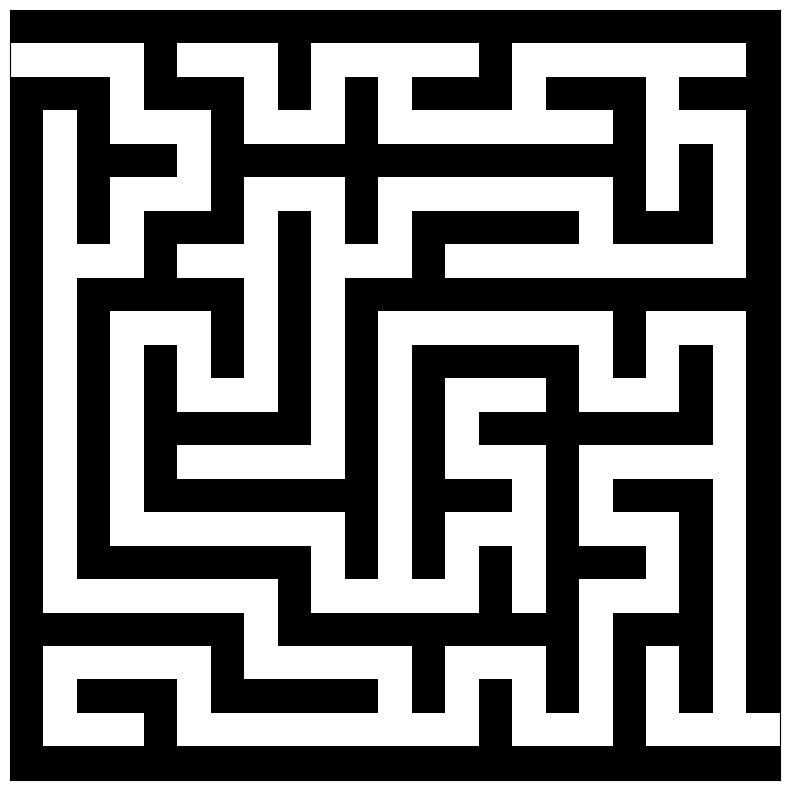

In [ ]:
# Create a maze and a quantum walk instance
maze = Maze(23, 23)
maze.display()

quantum_walk = QuantumWalk2D(maze)
quantum_walk.solve_maze(steps=10)  # Adjust the number of steps for the quantum walk